<a href="https://colab.research.google.com/github/eanasir/SSN-MEiL/blob/main/ssn_meil_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import numpy as np


class Loss_fcn:
  def __init__(self):
    self.functions = {
      'mse': self.mse,
      'bc_entropy': self.bc_entropy
      }
  def mse(self, expected, outputs, derivative=False):

    expected = np.asarray(expected, dtype=float)
    outputs = np.asarray(outputs, dtype=float)

    if not derivative:
      return 0.5 * (expected - outputs) ** 2
    else:
      return (outputs - expected)

  def bc_entropy(self,expected,outputs,derivative = False):

    expected = np.asarray(expected, dtype=float)
    outputs = np.asarray(outputs, dtype=float)

    if not derivative:
      return expected * np.log(outputs) + (1- expected) * np.log(1 - outputs)
    else:
      return (1 - expected) / (1- outputs) - (expected / outputs)

  def output(self,name, expected, outputs, derivative=False):
        if name not in self.functions:
            sys.exit(f"Error: Loss function '{name}' not found.")
        return self.functions[name](expected,outputs, derivative=derivative)

In [ ]:
import sys
import numpy as np

class Activation_fcn:
    def __init__(self):
        self.functions = {
            'linear':   self.linear,
            'sigmoid':  self.sigmoid,
            'logistic': self.logistic,
            'tanh':     self.tanh,
            'relu':     self.relu
        }

    def output(self, z, name, derivative=False):
        if name not in self.functions:
            sys.exit(f"Error: Activation function '{name}' not found.")
        return self.functions[name](z, derivative=derivative)

    def linear(self, z, derivative=False):
        if derivative:
            return np.ones_like(z)
        return z

    def sigmoid(self, z, derivative=False):
        s = 1.0 / (1.0 + np.exp(-z))
        if derivative:
            return s * (1.0 - s)
        return s

    def tanh(self, z, derivative=False):
        t = np.tanh(z)
        if derivative:
            return 1.0 - t**2
        return t

    def relu(self, z, derivative=False):
        if derivative:
            return (z >= 0).astype(z.dtype if np.issubdtype(z.dtype, np.number) else float)
        return np.maximum(0, z)

    def logistic(self, z, derivative=False):

        l = 1.0 / (1.0 + np.exp(-z - 0.5))
        if derivative:
            return l * (1.0 - l)
        return l


In [ ]:
class Neural_network:

    def __init__(self, structure=None, init_weight='rand'):
        self.af = Activation_fcn()
        if structure:
            self.network = self.create_network(structure, init_weight=init_weight)

    def create_network(self, structure, init_weight='rand'):
        self.nnetwork = [structure[0]]
        for i in range(1, len(structure)):
            new_layer = {
                'weights': None,
                'activation_function': structure[i]['activation_function'],
                'activation_potential': None,
                'delta': None,
                'output': None
            }
            out_u = structure[i]['units']
            in_u  = structure[i-1]['units']
            match init_weight:
                case "rand":
                    new_layer["weights"] = np.random.randn(out_u, in_u)
                case "zero":
                    new_layer["weights"] = np.zeros((out_u, in_u))
                case "ones":
                    new_layer["weights"] = np.ones((out_u, in_u))
                case _:
                    print("init weight not recognized")
            self.nnetwork.append(new_layer)
        return self.nnetwork

    def forward_propagate(self, nnetwork, inputs):
        A = np.asarray(inputs).reshape(-1, 1)
        for i in range(1, len(nnetwork)):
            W = nnetwork[i]["weights"]
            Z = W @ A
            A = self.af.output(Z, nnetwork[i]['activation_function'])
            nnetwork[i]['activation_potential'] = Z
            nnetwork[i]['output'] = A
        return A

    def predict(self, nnetwork, inputs):

        X = np.asarray(inputs)
        if X.ndim == 1:
            return self.forward_propagate(nnetwork, X).ravel()
        elif X.ndim == 2:

            outs = []
            for row in X:
                y = self.forward_propagate(nnetwork, row).ravel()
                outs.append(y)
            return np.vstack(outs)


    def train(self, nnetwork, x_train, y_train, l_rate=0.01, n_epoch=100, loss_function='mse'):
        for epoch in range(n_epoch):
            sum_error = 0
            for iter, (x_row, y_row) in enumerate(zip(x_train, y_train)):
                self.forward_propagate(nnetwork, x_row)
                loss = Loss_fcn()
                sum_error = np.sum(loss.output(loss_function, y_row, nnetwork[-1]['output'], derivative=False))
                self.backward_propagate(loss_function, nnetwork, y_row)
                self.update_weights(nnetwork, x_row, l_rate)
            #print('>epoch=%d, loss=%.3f' % (epoch + 1, sum_error))
        return nnetwork

    def backward_propagate(self, loss_function, nnetwork, expected):
        N = len(nnetwork) - 1
        loss = Loss_fcn()
        expected = np.asarray(expected).reshape(-1, 1)
        for i in range(N, 0, -1):
            if i == N:
                errors = loss.output(loss_function, expected, nnetwork[i]['output'],  derivative=True)
            else:
                errors = nnetwork[i+1]['weights'].T @ nnetwork[i+1]['delta']
            nnetwork[i]['delta'] = np.multiply(errors, self.af.output(nnetwork[i]['activation_potential'], nnetwork[i]['activation_function'], derivative=True))

    def update_weights(self, nnetwork, inputs, l_rate):
        inp = inputs
        for i in range(1, len(nnetwork)):
            A_prev = np.asarray(inp).reshape(-1, 1)
            delta = nnetwork[i]['delta']
            nnetwork[i]['weights'] -= l_rate * (delta @ A_prev.T)
            inp = nnetwork[i]['output']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def generate_regression_data(n=30):
    X = np.linspace(-5, 5, n).reshape(-1, 1)
    y = np.sin(2 * X) + np.cos(X) + 5
    data_noise = np.random.normal(0, 0.2, n).reshape(-1, 1)
    Y = y + data_noise
    return X.reshape(-1, 1), Y.reshape(-1, 1)


def test_regression():
    X, Y = generate_regression_data()
    model = Neural_network()
    structure = [
        {'type': 'input', 'units': 1},
        {'type': 'dense', 'units': 16, 'activation_function': 'sigmoid'},
        {'type': 'dense', 'units': 16, 'activation_function': 'sigmoid'},
        {'type': 'dense', 'units': 1, 'activation_function': 'linear'},
    ]
    network = model.create_network(structure)
    model.train(network, X, Y, l_rate=0.01, n_epoch=4000, loss_function='mse')
    predicted = model.predict(network, X)
    std = np.std(predicted - Y)
    print(f"\nStandard deviation = {std}")
    X_test = np.linspace(-7, 7, 100).reshape(-1, 1)
    predicted_test = model.predict(network, X_test)
    plt.plot(X, Y, 'r--o', label='Training data')
    plt.plot(X_test, predicted_test, 'b--x', label='Predicted')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_classification_data(n=30):
    # Class 1 - samples generation
    X1_1 = 1 + 4 * np.random.rand(n, 1)
    X1_2 = 1 + 4 * np.random.rand(n, 1)
    class1 = np.concatenate((X1_1, X1_2), axis=1)
    Y1 = np.ones(n)

    # Class 0 - samples generation
    X0_1 = 3 + 4 * np.random.rand(n, 1)
    X0_2 = 3 + 4 * np.random.rand(n, 1)
    class0 = np.concatenate((X0_1, X0_2), axis=1)
    Y0 = np.zeros(n)

    X = np.concatenate((class1, class0))
    Y = np.concatenate((Y1, Y0))

    idx0 = [i for i, v in enumerate(Y) if v == 0]
    idx1 = [i for i, v in enumerate(Y) if v == 1]

    return X, Y, idx0, idx1


def test_classification():
    # Read data
    X, Y, idx0, idx1 = generate_classification_data()

    # Create network
    model = Neural_network()

    structure = [
        {'type': 'input', 'units': 2},
        {'type': 'dense', 'units': 8, 'activation_function': 'relu'},
        {'type': 'dense', 'units': 8, 'activation_function': 'relu'},
        {'type': 'dense', 'units': 1, 'activation_function': 'logistic'}
    ]

    network = model.create_network(structure)

    model.train(network, X, Y,0.0001,2000,'bc_entropy')

    y = model.predict(network, X)

    # Compute accuracy
    t = 0.0
    for n, m in zip(y, Y):
        n = float(np.array(n).squeeze())
        m = float(m)
        t += 1.0 - abs(round(n) - m)
        print(f"pred = {n}, pred_round = {round(n)}, true = {m}")

    ACC = t / len(X)
    print(f"\nClassification accuracy = {ACC * 100:.2f}%")

    # Plotting decision regions
    xx, yy = np.meshgrid(
        np.arange(0, 8, 0.1),
        np.arange(0, 8, 0.1)
    )
    X_vis = np.c_[xx.ravel(), yy.ravel()]
    h = model.predict(network, X_vis)
    h = np.array(h).reshape(xx.shape) >= 0.5

    plt.contourf(xx, yy, h, cmap='jet')
    plt.scatter(X[idx1, 0], X[idx1, 1], marker='^', c="red", edgecolors="white", label="class 1")
    plt.scatter(X[idx0, 0], X[idx0, 1], marker='o', c="blue", edgecolors="white", label="class 0")
    plt.legend()
    plt.show()

pred = 0.5683691071379299, pred_round = 1, true = 1.0
pred = 0.35850898869358155, pred_round = 0, true = 1.0
pred = 0.08747538448611293, pred_round = 0, true = 1.0
pred = 0.07165481673518738, pred_round = 0, true = 1.0
pred = 0.16068197143299842, pred_round = 0, true = 1.0
pred = 0.16881048618975397, pred_round = 0, true = 1.0
pred = 0.3710567477358033, pred_round = 0, true = 1.0
pred = 0.5841091547684578, pred_round = 1, true = 1.0
pred = 0.14882134156611357, pred_round = 0, true = 1.0
pred = 0.13673352527200078, pred_round = 0, true = 1.0
pred = 0.1395777464439143, pred_round = 0, true = 1.0
pred = 0.10772540961969512, pred_round = 0, true = 1.0
pred = 0.09358398330007917, pred_round = 0, true = 1.0
pred = 0.1060289781872023, pred_round = 0, true = 1.0
pred = 0.32059645431907213, pred_round = 0, true = 1.0
pred = 0.09419933680373505, pred_round = 0, true = 1.0
pred = 0.1740718374009415, pred_round = 0, true = 1.0
pred = 0.10769800406750513, pred_round = 0, true = 1.0
pred = 0.3760844

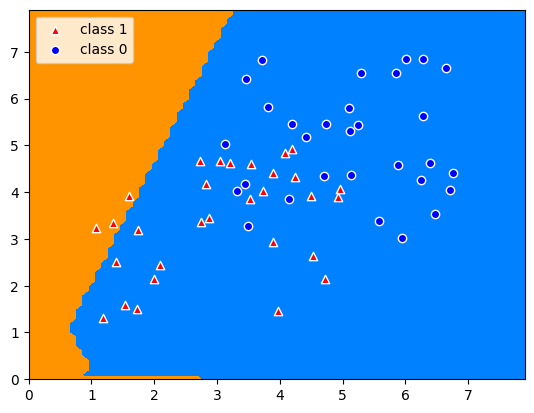

In [ ]:
test_classification()


Standard deviation = 0.5029801413172579


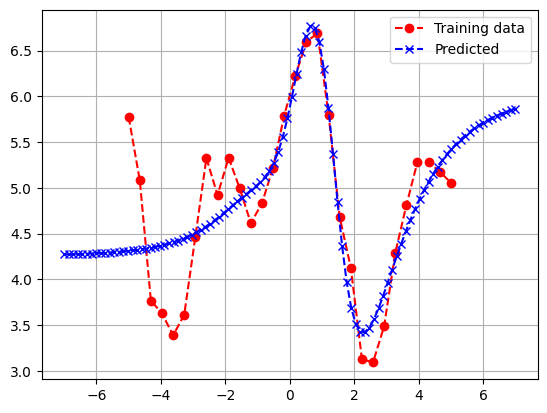

In [ ]:
test_regression()